# A Digit Classfier

## Pixels: The Foundations of Computer Vison
To demonstrate the concept of Computer Vision, we use a toy dataset 'MINST'

In [1]:
from fastai.vision.all import *

In [2]:
# Download MINST dataset 
path = untar_data(URLs.MNIST_SAMPLE)

In [3]:
# Set the path to the Dataset as a default basic path 
Path.BASE_PATH = path


In [4]:
# Check digital folders 
print(path.ls())
print((path/'train').ls())
print((path/'train'/'3').ls())
# Sort files based on their names 
three = (path/'train'/'3').ls().sorted()
seven = (path/'train'/'7').ls().sorted()
print(three)
print(seven)

[Path('valid'), Path('labels.csv'), Path('train')]
[Path('train/7'), Path('train/3')]
[Path('train/3/49081.png'), Path('train/3/51816.png'), Path('train/3/39566.png'), Path('train/3/24251.png'), Path('train/3/20989.png'), Path('train/3/29013.png'), Path('train/3/58832.png'), Path('train/3/9294.png'), Path('train/3/20023.png'), Path('train/3/36899.png'), Path('train/3/54952.png'), Path('train/3/45687.png'), Path('train/3/3949.png'), Path('train/3/29991.png'), Path('train/3/47090.png'), Path('train/3/10876.png'), Path('train/3/56823.png'), Path('train/3/25601.png'), Path('train/3/37205.png'), Path('train/3/6825.png'), Path('train/3/8808.png'), Path('train/3/12913.png'), Path('train/3/42117.png'), Path('train/3/12720.png'), Path('train/3/43209.png'), Path('train/3/4001.png'), Path('train/3/19675.png'), Path('train/3/10137.png'), Path('train/3/41378.png'), Path('train/3/16220.png'), Path('train/3/54013.png'), Path('train/3/22185.png'), Path('train/3/6170.png'), Path('train/3/52476.png'), P

In [118]:
# check out the image 
im3 = Image.open(three[1])
im3

In [6]:
# Convert image format to numpy array or Pytorch tensor 
print(array(im3)[4:10, 4:10])
print(tensor(im3)[4:10, 4:10])

[[  0   0   0   0   0   0]
 [  0   0   0   0   0  29]
 [  0   0   0  48 166 224]
 [  0  93 244 249 253 187]
 [  0 107 253 253 230  48]
 [  0   3  20  20  15   0]]
tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)


In [7]:
# Using pandas DataFrame to color-code the values using a gradient 
im3_t = tensor(im3)
df = pd.DataFrame(im3_t)
df.style.set_properties(**{'font-size': '6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0,0,0,0,0,0,0


## A baseline model: Pixel Similarity 
How does a computer might be able to recognize these two digits? Naively speaking, an ideal image is used to be compared with every image from pixel to pixel. The MAE or MSE can be used as a metric. This is a baseline model, becuase it is difficult to tell images when we shift digit in some images.


In [8]:
three_tensors = [tensor(Image.open(s)) for s in three]
seven_tensors = [tensor(Image.open(s)) for s in seven]
len(three_tensors), len(seven_tensors)

(6131, 6265)

<Axes: >

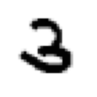

In [9]:
# Convert an pixel tensor to an image 
matplotlib.rc('image', cmap = "Greys")
show_image(three_tensors[5])


Applying tensor broadcasting to calculate the distance between an image from valid dataset and the ideal image 3 or 7

In [10]:
# add an new dimesnion dim=0 and normalized it, and get an average ideal image
stack_threes = torch.stack(three_tensors).float()/255
stack_sevens = torch.stack(seven_tensors).float()/255
ave_threes = stack_threes.mean(0)
ave_sevens = stack_sevens.mean(0)

<Axes: >

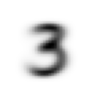

In [11]:
show_image(ave_threes)

Define metrics 
1. Define a 'distance' between an ideal image and an image that is needed to predict:
- L1 norm: mean absolute error (MAE)
- L2 norm: root mean squared error (RMSE)

In [12]:
(path/'valid'/'3').ls()

(#1010) [Path('valid/3/3975.png'),Path('valid/3/1804.png'),Path('valid/3/4940.png'),Path('valid/3/5492.png'),Path('valid/3/5479.png'),Path('valid/3/8607.png'),Path('valid/3/7252.png'),Path('valid/3/4983.png'),Path('valid/3/3746.png'),Path('valid/3/5860.png'),Path('valid/3/7905.png'),Path('valid/3/1384.png'),Path('valid/3/9914.png'),Path('valid/3/9727.png'),Path('valid/3/63.png'),Path('valid/3/2128.png'),Path('valid/3/8411.png'),Path('valid/3/3381.png'),Path('valid/3/2921.png'),Path('valid/3/9860.png')...]

In [13]:
valid_tensor_threes = torch.stack([tensor(Image.open(s)) for s in (path/'valid'/'3').ls()])
valid_tensor_sevens = torch.stack([tensor(Image.open(s)) for s in (path/'valid'/'7').ls()])
valid_tensor_threes = valid_tensor_threes.float()/255
valid_tensor_sevens = valid_tensor_sevens.float()/255
valid_tensor_threes.shape, valid_tensor_sevens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [14]:
def mnist_mae(a, b):
    return (a-b).abs().mean((-1,-2)) # The argument (-1, -2) specifies which dimensions to average over

def mnist_rmse(a, b):
    return ((a-b)**2).abs().mean((-1, -2))

a_3 = stack_threes[1]
print('mae:', mnist_mae(a_3, ave_threes), mnist_mae(a_3, ave_sevens))
print('rmse:', mnist_rmse(a_3, ave_threes), mnist_rmse(a_3, ave_sevens))

mae: tensor(0.1114) tensor(0.1586)
rmse: tensor(0.0408) tensor(0.0913)


In [15]:
valid_3_dist = mnist_mae(valid_tensor_threes, ave_threes)
valid_3_dist = mnist_rmse(valid_tensor_sevens, ave_threes)

In [16]:
def is_3(x):
    return mnist_mae(x, ave_threes) < mnist_mae(x, ave_sevens)
def is_7(x):
    return mnist_mae(x, ave_sevens) < mnist_mae(x, ave_threes)
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

The accuracy 

In [17]:
# Acuracy:
accuracy_3s = is_3(valid_tensor_threes).float().mean()
accuracy_7s = is_7(valid_tensor_sevens).float().mean()
accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

In [18]:
#Note numpy array can be a jagged array throght setting dtype = object, while tensor is only a multidimensional table of data.
#Pytorch tensor structures can live on GPU, optimize their computation for GPU, and calculate derivatives of these operations. 
array([array([1]),array([2,3])], dtype = object)

array([array([1]), array([2, 3])], dtype=object)

Observation: we obtained over 90% accruracy on both 3s and 7s. 
'3' and '7' are very different-looking. We are going to need to do better
Let us develop another model to automatically modify itself to improve performance

# Stochastic Gradient Descent 
This algrithem is based on steepest descent
$$
f(x_0 + \delta x) = f(x_0) + f^{\prime} (x_0)\delta x +O(\delta x^2)
$$
Here, we set $\delta x = -\lambda f^{\prime}(x_0)$ and the learning rate is $\lambda >0$. It can enable $f(x)$ constantly descreases regardless of $x_0$ being positive or negative.  

In [119]:
from functools import partial
def quad(a, b, c, x):
    return a*x**2 + b*x + c 
def mk_quad(a, b, c):
    return partial(quad, a, b, c)

f = mk_quad(3, 2, 1)
f(1.5)


10.75

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


(-3.0, 20.0)

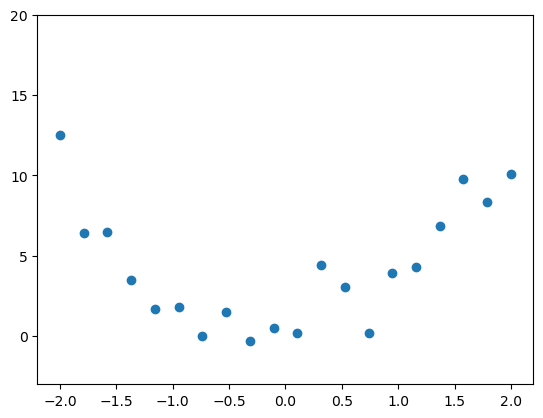

In [20]:
from numpy.random import normal, seed, uniform 
np.random.seed(42)
def noise(x, scale):
    return normal(scale = scale, size = x.shape) # scale: invariance; size: the number of random numers
def add_noise(x, mult, add):
    return x*(1+noise(x, mult))+noise(x, add)
def g_mse(preds, acts):
    return ((preds-acts)**2).mean()
x = torch.linspace(-2, 2, steps = 20)[:, None]
print(type(x))
y = add_noise(f(x), 0.3, 1.5)
print(type(x))
print(type(g_mse(f(x), y)))
plt.scatter(x, y)
plt.ylim(-3, 20)

In [21]:
from ipywidgets import interact
from fastbook import *
#import torch.nn.functional as F


@interact(a=1.5, b=1.5, c=1.5)
def plot_quad(a, b, c):
    f = mk_quad(a, b, c)
    #x = torch.linspace(-2, 2, steps = 20)[:, None]
    #y = add_noise(f(x), 0.3, 1.5)  
    #print(type(f(x)))
    #print(type(y))
    loss = g_mse(f(x), y) # I do not know why this type of loss is TensorBase
    #loss1 = loss.as_subclass(torch.Tensor)
    #print(type(loss1))  
    plot_function(f,  min= -2, max= 2, title = f"MSE:{loss:.2f}")
    plt.scatter(x, y)

    

interactive(children=(FloatSlider(value=1.5, description='a', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

Note: mse is an inherent function from fastai, the type of return from mse is TensorBase

In [22]:
def quad_mse(params):
    f = mk_quad(*params)
    return g_mse(f(x), y)
quad_mse([1.5, 1.5, 1.5])

tensor(5.8336, dtype=torch.float64)

In [23]:
abc = torch.tensor([1.5, 1.5, 1.5])
abc.requires_grad_()
print(abc)
loss = quad_mse(abc)
loss.backward()

tensor([1.5000, 1.5000, 1.5000], requires_grad=True)


In [24]:
abc.grad

tensor([-5.1419,  2.8472, -1.1009])

In [25]:
with torch.no_grad():
    abc -= abc.grad*0.01
    loss = quad_mse(abc)
print(f'loss: {loss:.2f}')

loss: 5.49


In [26]:
# immutable: () 
# mutable: list, abc
def learning(abc, step, lam):
    abc_c = abc.clone().detach()
    abc_c.requires_grad_()
    for i in range(step):
        loss = quad_mse(abc_c)
        loss.backward()
        with torch.no_grad():
            abc_c -= abc_c.grad * lam
        print(f'step={i}; loss={loss:.2f}')
    return abc_c

abc_c = learning(abc, 6, 0.01)
abc_c = learning(abc_c, 22, 0.005)
abc_c = learning(abc_c, 27, 0.001)
abc_c = learning(abc_c, 150, 0.0005)

step=0; loss=5.49
step=1; loss=5.19
step=2; loss=4.69
step=3; loss=4.11
step=4; loss=3.61
step=5; loss=3.30
step=0; loss=3.23
step=1; loss=3.20
step=2; loss=3.15
step=3; loss=3.08
step=4; loss=3.01
step=5; loss=2.93
step=6; loss=2.86
step=7; loss=2.80
step=8; loss=2.76
step=9; loss=2.74
step=10; loss=2.73
step=11; loss=2.72
step=12; loss=2.73
step=13; loss=2.73
step=14; loss=2.72
step=15; loss=2.71
step=16; loss=2.68
step=17; loss=2.65
step=18; loss=2.62
step=19; loss=2.60
step=20; loss=2.58
step=21; loss=2.57
step=0; loss=2.59
step=1; loss=2.58
step=2; loss=2.58
step=3; loss=2.58
step=4; loss=2.57
step=5; loss=2.57
step=6; loss=2.56
step=7; loss=2.55
step=8; loss=2.54
step=9; loss=2.53
step=10; loss=2.52
step=11; loss=2.51
step=12; loss=2.50
step=13; loss=2.49
step=14; loss=2.48
step=15; loss=2.47
step=16; loss=2.45
step=17; loss=2.44
step=18; loss=2.43
step=19; loss=2.42
step=20; loss=2.41
step=21; loss=2.40
step=22; loss=2.39
step=23; loss=2.39
step=24; loss=2.38
step=25; loss=2.38


Take a simple example to demostrate the derivative $y=x^2$

In [27]:
def square(x_t):
    return x_t**2
x_t = tensor(1.0)
x_t.requires_grad_()
y_t = square(x_t)
y_t.backward()
x_t.grad

tensor(2.)

In [28]:
# tensor.clone().detach().requires_grad_() v.s. tensor.clone()
def square(x_t):
    return x_t**2
x_t = tensor(1.0)
x_t.requires_grad_()
y_t = square(x_t)
yc_t = y_t.clone()
print(yc_t.requires_grad)
yc_t.backward()

print(x_t.grad)
x_t.grad.zero_()
yc1_t = yc_t.detach().requires_grad_()
print(yc1_t.requires_grad)
yc1_t.backward()
x_t.grad
yc1_t.grad


True
tensor(2.)
True


tensor(1.)

# The MNIST Loss Function

In [29]:
# cook train dataset 
train_x = torch.cat([stack_threes, stack_sevens]).view(-1, 28*28)
print(f'three shape, seven shape : {stack_threes.shape}, {stack_sevens.shape}')
print(f'train x shape: {train_x.shape}')
train_y = tensor([1]*stack_threes.shape[0]+[0]*stack_sevens.shape[0]).unsqueeze(1) # add a new dimension
print(f'train y shape: {train_y.shape}')
dataset = list(zip(train_x, train_y))

three shape, seven shape : torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28])
train x shape: torch.Size([12396, 784])
train y shape: torch.Size([12396, 1])


In [30]:
# cook validation dataset 
valid_x = torch.cat([valid_tensor_threes, valid_tensor_sevens]).view(-1, 28*28)
valid_y = tensor([1]*valid_tensor_threes.shape[0]+[0]*valid_tensor_sevens.shape[0]).unsqueeze(1)
valid_dataset = list(zip(valid_x, valid_y))

Define an initialization function, that initially gives every pixel a random weight 

In [31]:
def init_params(size, std = 1.0):
    return (torch.randn(size)*std).requires_grad_()
weights = init_params((28*28, 1))
bias = init_params(1)

In [32]:
print(train_x[0].shape)
print(weights.shape)
train_x[0].T

torch.Size([784])
torch.Size([784, 1])


/var/folders/mw/x3dsjtbx02xbvdbx32dnk4rc0000gn/T/ipykernel_34755/1911532877.py:3: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3687.)
  train_x[0].T


tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,


In [33]:
aa = tensor([1, 2, 3])
bb = tensor([[1], [2], [3]])
print(aa.shape)
print(bb.shape)
print(bb.T)
print((aa * bb.T).shape)
print(aa*bb.T)

torch.Size([3])
torch.Size([3, 1])
tensor([[1, 2, 3]])
torch.Size([1, 3])
tensor([[1, 4, 9]])


In [34]:
(weights.T*train_x[0]).sum() + bias 

tensor([-6.2330], grad_fn=<AddBackward0>)

Using matrix multiplication 

In [35]:
def linear1(xb):
    return xb@weights + bias 

preds = linear1(train_x)
preds

tensor([[ -6.2330],
        [-10.6388],
        [-20.8865],
        ...,
        [-15.9176],
        [ -1.6866],
        [-11.3568]], grad_fn=<AddBackward0>)

Observe that a variation in the accuracy induced by a change of coefficient 

In [36]:
corrects = (preds > 0.0).float() == train_y
corrects.float().mean()

tensor(0.5380)

In [37]:
with torch.no_grad():
    weights[0] = weights[0]*1.0001
preds = linear1(train_x)
corrects = (preds > 0.0).float() == train_y
corrects.float().mean()

tensor(0.5380)

The conclustion: the accuracy remains the same when the coefficient varies. Therefore, An accuracy or a metrics is not an appropriate function for the optimizing coefficients. We have to create a differentiable function to make it. This function is called as a loss function.

loss function 

we use sigmoid function to map a linear value to a pobability value. This probability means predicting sth with certain confidence.
When `preds.sigmoid()>0.5` means 


In [38]:
#help(torch.where)
def mnist_loss(preds, targs):
    return torch.where(targs==1, 1-preds.sigmoid(), preds.sigmoid()).mean()

In [39]:
a = tensor([1,2,3]).unsqueeze(1)
b = tensor([1, 0, 1]).unsqueeze(1)
mnist_loss(a, b)

tensor(0.3991)

In [40]:
tensor([1,2,3]).unsqueeze(1)

tensor([[1],
        [2],
        [3]])

tensor([1,2,3]).unsqueeze(1)

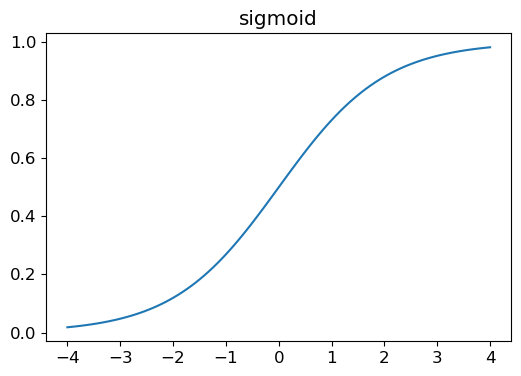

In [41]:
tensor([1 ,2 ,3]).sigmoid()
plot_function(torch.sigmoid, min=-4, max=4, title='sigmoid')

# SGD and Mini-Batches

Let us go to the phase of the learning process, which is to update the weights based on the gradients (optimization step).

## Let us implement the optimization step.

In [42]:
# demonstrate how to use DataLoader 
coll = range(10)
dl = DataLoader(coll, batch_size = 5, shuffle = True)
list(dl)

[tensor([3, 8, 2, 5, 4]), tensor([7, 9, 1, 0, 6])]

In [43]:
ds = L(enumerate(string.ascii_lowercase))
dl_ds = DataLoader(ds, batch_size = 6, shuffle = True)
print(list(dl_ds))
dl_ds = DataLoader(ds, batch_size = 6)
print(list(dl_ds))


[(tensor([17, 18, 10, 22,  8, 14]), ('r', 's', 'k', 'w', 'i', 'o')), (tensor([20, 15,  9, 13, 21, 12]), ('u', 'p', 'j', 'n', 'v', 'm')), (tensor([ 7, 25,  6,  5, 11, 23]), ('h', 'z', 'g', 'f', 'l', 'x')), (tensor([ 1,  3,  0, 24, 19, 16]), ('b', 'd', 'a', 'y', 't', 'q')), (tensor([2, 4]), ('c', 'e'))]
[(tensor([0, 1, 2, 3, 4, 5]), ('a', 'b', 'c', 'd', 'e', 'f')), (tensor([ 6,  7,  8,  9, 10, 11]), ('g', 'h', 'i', 'j', 'k', 'l')), (tensor([12, 13, 14, 15, 16, 17]), ('m', 'n', 'o', 'p', 'q', 'r')), (tensor([18, 19, 20, 21, 22, 23]), ('s', 't', 'u', 'v', 'w', 'x')), (tensor([24, 25]), ('y', 'z'))]


In [69]:
dss = [(1, 'a'), (2, 'a'), (3, 'a'), (4, 'b'), (5, 'b'), (6, 'b'),(7, 'b')]
dl_dss = DataLoader(dss, batch_size = 3, shuffle = True)
list(dl_dss)

[(tensor([6, 5, 2]), ('b', 'b', 'a')),
 (tensor([7, 4, 3]), ('b', 'b', 'a')),
 (tensor([1]), ('a',))]

In [44]:
dl = DataLoader(dataset, batch_size = 256)
valid_dl = DataLoader(valid_dataset, batch_size = 256)
xb, yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [45]:
batch = train_x[:4]
print(batch.shape)
preds = linear1(batch)
print(preds)
loss = mnist_loss(preds, train_y[:4])
print(loss)
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

torch.Size([4, 784])
tensor([[ -6.2330],
        [-10.6388],
        [-20.8865],
        [-17.8700]], grad_fn=<AddBackward0>)
tensor(0.9995, grad_fn=<MeanBackward0>)


(torch.Size([784, 1]), tensor(-7.0675e-05), tensor([-0.0005]))

In [46]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    #print(loss)
    loss.backward()

calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(), bias.grad

(tensor(-0.0001), tensor([-0.0010]))

In [47]:
# To understand that loss.backward adds the gradients of loss to any gradients that are currently stored, we take an example to demonstrate it.
aa = tensor(3.0).requires_grad_()
for j in range(3):
    print(f'aa gradient before: {aa.grad}')
    yaa = aa**2
    yaa.backward()
    print(f'aa gradient after: {aa.grad}')
    #aa.grad.zero_()


aa gradient before: None
aa gradient after: 6.0
aa gradient before: 6.0
aa gradient after: 12.0
aa gradient before: 12.0
aa gradient after: 18.0


In [48]:
x = torch.tensor(3.0, requires_grad=True)
y = x ** 2  # calculate  y = x^2
y.backward()  # dy/dx = 2x = 6, and the computational graph is cleared
print(x.grad)  # output: tensor(6.)
print(x)

x.data -= 1  # revise the value of x, but it is not told to computational graph 
#x = x + 1 # it is told to computational graph
print(x.requires_grad)
#x.grad.zero_()
print(x)
y = x ** 2 # reclaim the function 
x.grad.zero_()
y.backward()
print(x.grad) 

tensor(6.)
tensor(3., requires_grad=True)
True
tensor(2., requires_grad=True)
tensor(4.)


In [49]:
def train_epoch(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [50]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

batch_accuracy(linear1(batch), train_y[:4])

tensor(0.)

In [51]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4) 
validate_epoch(linear1)

0.5475

In [52]:
lr = 1.0
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.7308

In [53]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end =' ')

0.8505 0.9012 0.9291 0.9388 0.9442 0.9525 0.9545 0.9589 0.9613 0.9623 0.9623 0.9633 0.9637 0.9647 0.9662 0.9667 0.9672 0.9672 0.9677 0.9682 

# Creating an Optimizer
PyTorch provides some useful classes to make it easier to implement.
1. linear function --> PyTorch `nn.Linear` module. 
2. module

In [54]:
linear_model = nn.Linear(28*28, 1)
w, b = linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [56]:
class BasicOptim:
    def __init__(self, params, lr):
        self.params, self.lr = list(params), lr
    def step(self, *args, **kwargs):
        for p in self.params:
            p.data -=p.grad.data*self.lr
    def zero_grad(self, *arg, **kwargs):
        for p in self.params:
            p.grad = None

opt = BasicOptim(linear_model.parameters(), lr)
                

In [58]:
def train_epoch(model):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [55]:
validate_epoch(linear_model)

0.7236

In [59]:
train_model(linear_model, 20)

0.4932 0.7861 0.8574 0.916 0.936 0.9502 0.956 0.9629 0.9668 0.9678 0.9697 0.9717 0.9741 0.9746 0.9761 0.9775 0.9775 0.978 0.9785 0.9785 

fastai provides the SGD class that does the same thing as our BasicOptims

In [61]:
linear_model = nn.Linear(28*28, 1)
opt=SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.7827 0.8486 0.915 0.9355 0.9487 0.956 0.9634 0.9658 0.9678 0.9687 0.9712 0.9736 0.9751 0.9756 0.977 0.9775 0.9775 0.978 0.9785 

Instead of train_model, we can use Learner.fit from fastai. To create a Learner, we first need to create a DataLoaders, 
by passing in our training and validation DataLoaders:

In [82]:
dls = DataLoaders(dl, valid_dl)
# Learner(`DataLoaders`, `model`,  'the optimization function', 'the loss function', 'metrics')
learn = Learner(dls, nn.Linear(28*28, 1), opt_func = SGD, loss_func = mnist_loss, metrics = batch_accuracy)
learn.fit(5, lr = lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.637081,0.503324,0.495584,00:00
1,0.477936,0.209056,0.819431,00:00
2,0.176965,0.173999,0.842983,00:00
3,0.078373,0.104444,0.912659,00:00
4,0.042085,0.076936,0.931796,00:00


# Adding a Nonlinearity 

In [ ]:
# simple neural network 
def simple_net(xb):
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 +b2
    return res 

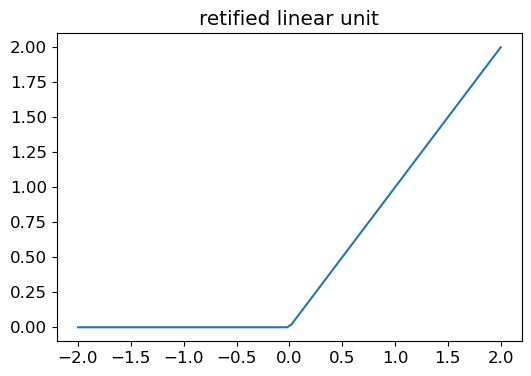

In [88]:
plot_function(F.relu, title = 'retified linear unit')

In [101]:
# We can use PyTorch in-built models. 
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)
learn = Learner(dls, simple_net, opt_func = SGD, 
                loss_func = mnist_loss, metrics = batch_accuracy)
learn.fit(12, 0.1)
#plt.plot(L(learn.recorder.values).itemgot(2))
L(learn.recorder.values).itemgot(2)
learn.recorder.values[0][2]


epoch,train_loss,valid_loss,batch_accuracy,time
0,0.305123,0.401432,0.509323,00:00
1,0.142298,0.225969,0.810108,00:00
2,0.079564,0.114266,0.916094,00:00
3,0.052729,0.077294,0.941609,00:00
4,0.040198,0.060336,0.958783,00:00
5,0.033747,0.050802,0.965162,00:00
6,0.030016,0.044789,0.966143,00:00
7,0.027574,0.040683,0.968106,00:00
8,0.025806,0.037695,0.969578,00:00
9,0.024431,0.035418,0.971541,00:00


0.5093228816986084

# Questionnaire
1. How is a grayscale image represented on a computer? How about a color image?

- Answer: 

a. A grayscale image is reprensented as a matrix, for example 28*28. Each element in the matrix is called as pixel, and the value of each pixel represents its intensity, varying between 0 (black) and 255 (white) in 8-bit representation.

b. A color image is represented as also a matrix, but the value for each pixel is a tuple of three numbers, and describes intensity levels for red, green and blue (typically from 0 to 255).

2. How are the files and folders in the MNIST_SAMPLE dataset structured? Why?

- Answer:

Mnist_Sample dataset is structured as the following way: In the base path, there are three folders 'valid', 'train', 'labels.csv'. Train dataset and Validation dataset are well-orgnized. In details, In 'train' folder, all images of three are placed in '3' folder, and all images of seven are placed in '7' folder. Every image is well grouped, and making it easy image classification.    

3. Explain how the “pixel similarity” approach to classifying digits works.

-Answer: This approach first creates two ideal images for '3' and '7', and then compares each image that needs to predict to these two ideal images.  To classify an image as '3' or '7'. We see which of two ideal images the image is similar to.

4. What is a list comprehension? Create one now that selects odd numbers from a list and doubles them.

-Answer: list comprehension is a way to create a list. It allows you to use a single line code.
`aa = [e for e in range(n) if e%2 ==1]`
`bb =[2*e for e in aa ]`

5. what is a rank-3 tensor?

- Answer: the rank of a tensor means how many indexes needed to locate an element. For example, A rank-2 tensor, that is a matrix, needs two indexes to locate an ellemnt.


6. What is the difference between tensor rank and shape? How do you get the rank from the shape?

- Answer: the shape means how many dimensions are there at each index of a tensor. We get the rank using 
`len(tensor([[1,2],[3,4],[5,6]]).shpae)` 
7. What are RMSE and L1 norm?

- Answer: RMSE is the square root of MSE, where MSE is the mean square error. MSE is obtained through making summation over all the squares of each difference between a predited value and a truth value. L1 norm is MAE, which is obtained through making summation over all the absolute values of each difference between a predited value and a truth value. 


8. How can you apply a calculation on thousands of numbers at once, many thou‐ sands of times faster than a Python loop?

- Answer: 
9. Create a 3×3 tensor or array containing the numbers from 1 to 9. Double it. Select the bottom-right four numbers.

- Answer:
`a = tensor(range(1, 10)).view(3,3)`
`a = 2*a`
`a[-1,-1]`
10. What is broadcasting?

- Answer: 

Broadcasting means a smaller rank tensor or array 


In [113]:
ff = [e for e in range(10) if e%2 ==1]
tensor([[1,2],[3,4],[5,6]]).shape

torch.Size([3, 2])

In [117]:
aa= tensor(range(1, 10)).view(3,3)
aa[-1,-1]

tensor(9)